In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import time

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# Activate the growth of memory for a specific GPU
# https://www.tensorflow.org/guide/gpu

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
tf.debugging.set_log_device_placement(True)

1 Physical GPUs, 1 Logical GPUs


# Load datasets

I generated several datasets (in the same way). So I concatenate them to build a single training, validateion and testing datasets


In [8]:
# path to directory where data are stored
path = ""

# path to label/parameters, parameters are stored in dataframes
path_to_label0 = path+"0scaled_params.csv"
path_to_label1 = path+"1scaled_params.csv"
path_to_label2 = path+"2scaled_params.csv"
path_to_label3 = path+"3scaled_params.csv"
path_to_label4 = path+"4scaled_params.csv"

# path to inputs 
path_to_input0 = path+"0CBLV.npy"
path_to_input1 = path+"1CBLV.npy"
path_to_input2 = path+"2CBLV.npy"
path_to_input3 = path+"3CBLV.npy"
path_to_input4 = path+"4CBLV.npy"

# parameters that we want to infer.
# In particular, for now we don't want to infer the sampling probability.
params_to_infer = ["mean_signal", "amplitude", "import_param"]

nb_estimates = len(params_to_infer)

inputs0 = np.transpose(np.load(path_to_input0), axes=(0, 2, 1))
inputs1 = np.transpose(np.load(path_to_input1), axes=(0, 2, 1))
inputs2 = np.transpose(np.load(path_to_input2), axes=(0, 2, 1))
inputs3 = np.transpose(np.load(path_to_input3), axes=(0, 2, 1))
inputs4 = np.transpose(np.load(path_to_input4), axes=(0, 2, 1))

labels0 = pd.read_csv(path_to_label0)[params_to_infer].to_numpy()
labels1 = pd.read_csv(path_to_label1)[params_to_infer].to_numpy()
labels2 = pd.read_csv(path_to_label2)[params_to_infer].to_numpy()
labels3 = pd.read_csv(path_to_label3)[params_to_infer].to_numpy()
labels4 = pd.read_csv(path_to_label4)[params_to_infer].to_numpy()


# Check shapes
print('inputs shape:', inputs0.shape)
print('labels shape:', labels0.shape)
print('inputs shape:', inputs1.shape)
print('labels shape:', labels1.shape)
print('inputs shape:', inputs2.shape)
print('labels shape:', labels2.shape)
print('inputs shape:', inputs3.shape)
print('labels shape:', labels3.shape)
print('inputs shape:', inputs4.shape)
print('labels shape:', labels4.shape)

inputs shape: (16689, 600, 2)
labels shape: (16689, 3)
inputs shape: (146378, 600, 2)
labels shape: (146378, 3)
inputs shape: (172287, 600, 2)
labels shape: (172287, 3)
inputs shape: (233439, 600, 2)
labels shape: (233439, 3)
inputs shape: (274119, 600, 2)
labels shape: (274119, 3)


In [48]:
# Here, I don't take the 600 first elements of inputs4 because they will be my testing data
inputs = np.concatenate((inputs3, inputs4[600:,]), axis=0)
labels = np.concatenate((labels3, labels4[600:,]), axis=0)

# inputs = np.concatenate((inputs0, inputs1, inputs2, inputs3, inputs4), axis=0)
# labels = np.concatenate((labels0,labels1, labels2, labels3, inputs4), axis=0)

print("label concatenation: ", labels.shape)
print("input concatenation:", inputs.shape)

label concatenation:  (506958, 3)
input concatenation: (506958, 600, 2)


## *Normalize Inputs and Outputs*

In [ ]:
# I compute the bound values of inputs and output once on all the data I have generated 
# MAX_features = np.max(inputs, axis=(0,1))
# MIN_labels = np.min(labels, axis=0)
# MIN_labels[1] = 0.1
# MAX_labels = np.max(labels, axis=0)
# MAX_labels[1], MAX_labels[2] = 1, 15

# Then I saved it
# np.save(path+"bound_features.npy", MAX_features)
# np.save(path+"bound_labels.npy", np.concatenate((MAX_labels, MIN_labels), axis=0))

In [49]:
# Here, I load the maximum and minimum of each features and labels
MAX_features = np.load(path+"bound_features.npy")
E = np.load(path+"bound_labels.npy")
MAX_labels, MIN_labels = E[:3], E[3:]

In [50]:
print(MAX_features)
print(MIN_labels)
print(MAX_labels)

norm_inputs = inputs/MAX_features[None, :]
norm_labels = (labels-MIN_labels[None, :])/(MAX_labels[None, :]-MIN_labels[None, :])

print(norm_inputs.shape)
print(norm_labels.shape)

[59.15544517 57.92463666]
[2.10405211 0.1        0.01231017]
[ 8.49434372  1.         15.        ]
(506958, 600, 2)
(506958, 3)


In [54]:
PROP_TRAIN =  0.98
num_train = int(labels.shape[0]*PROP_TRAIN)

x_train, y_train = norm_inputs[:num_train, :, :], norm_labels[:num_train, :]
x_val, y_val = norm_inputs[num_train:, :, :], norm_labels[num_train:, :]
                                                                
train_size = x_train.shape[0]
print(f"There is {train_size} training data, {x_val.shape[0]} validation data")

There is 496818 training data, 10140 validation data


# Design models

In [14]:
SIZE = 600
inp = tf.random.normal((1, SIZE, 2))

CNN_1 = keras.Sequential(
    [
        keras.Input(shape=(SIZE, 2)),
        layers.Conv1D(filters=50, kernel_size=3),   
        layers.Activation(keras.activations.relu),
        layers.Conv1D(filters=50, kernel_size=10),
        layers.Activation(keras.activations.relu),
        layers.MaxPooling1D(pool_size=10),
        layers.Conv1D(filters=80, kernel_size=10),
        layers.Activation(keras.activations.relu),
        # layers.Dropout(.5),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64),
        layers.Activation(keras.activations.elu),
        layers.Dense(32),
        layers.Activation(keras.activations.elu),
        layers.Dense(16),
        layers.Activation(keras.activations.elu),
        layers.Dense(8),
        layers.Activation(keras.activations.elu),
        layers.Dropout(.2),
        layers.Dense(nb_estimates)
    ]
)
print('CNN1 ')
CNN_1.summary()
print("\ntest out", CNN_1(inp), '\n')


CNN_flat = keras.Sequential(
    [
        keras.Input(shape=(SIZE, 2)),
        layers.Conv1D(filters=50, kernel_size=3),
        layers.Activation(keras.activations.relu),
        layers.MaxPooling1D(pool_size=10),
        layers.Conv1D(filters=80, kernel_size=10),
        layers.Activation(keras.activations.relu),
        # layers.Dropout(.5),
        layers.Flatten(),
        layers.Dense(1024, activation="elu"),
        layers.Dense(128),
        # layers.Dropout(.2),
        # layers.BatchNormalization(),
        layers.Activation(keras.activations.elu),
        layers.Dense(64),
        # layers.Dropout(.2),
        # layers.BatchNormalization(),
        layers.Activation(keras.activations.elu),
        layers.Dense(32),
        # layers.Dropout(.2),
        # layers.BatchNormalization(),
        layers.Activation(keras.activations.elu),
        layers.Dense(16),
        # layers.BatchNormalization(),
        layers.Activation(keras.activations.elu),
        layers.Dense(8),
        layers.Activation(keras.activations.elu),
        layers.Dropout(.5),
        layers.Dense(nb_estimates)
    ]
)
print('CNN_flat')
CNN_flat.summary()
print('\ntest out', CNN_flat(inp), '\n')


CNN_big = keras.Sequential(
    [
        keras.Input(shape=(SIZE, 2)),
        layers.Conv1D(filters=60, kernel_size=3),
        layers.Activation(keras.activations.relu),
        # layers.BatchNormalization(),
        layers.Conv1D(filters=60, kernel_size=10),
        layers.Activation(keras.activations.relu),
        # layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.MaxPooling1D(pool_size=10),
        layers.Conv1D(filters=100, kernel_size=10),
        layers.Activation(keras.activations.relu),
        # layers.BatchNormalization(),
        layers.Dropout(.5),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation="elu"),
        # layers.Dropout(.5),
        layers.Dense(32, activation="elu"),
        layers.Dense(16, activation="elu"),
        layers.Dense(8, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(nb_estimates, activation="linear")
    ]
)
print('CNN Big')
CNN_big.summary()
print('\ntest out', CNN_big(inp), '\n')

CNN1 
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 598, 50)           350       
_________________________________________________________________
activation_85 (Activation)   (None, 598, 50)           0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 589, 50)           25050     
_________________________________________________________________
activation_86 (Activation)   (None, 589, 50)           0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 58, 50)            0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 49, 80)            40080     
_________________________________________________________________
activation_87 (Activation)   (None, 49, 80)    

# Training

In [17]:
def training(model, batch_size=64, num_epochs = 1000, patience=200, min_diff=0.5, loss=tf.keras.losses.MeanAbsolutePercentageError(), optim="adam"):
    """
    Train the model 
    
    Parameters
    --------------------------
    model : model of neural network to train
    min_diff, patience : int, parameters of the early stopping. 
                         If the difference of val loss is less than min_diff during more than patience iterations, the training stops
    
    Returns
    --------------------------
    The history of training
    
    """
    custom_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=min_diff, patience=patience)
    model.compile(
        optimizer=optim,
        loss=loss,
    )
    
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=num_epochs, callbacks=[custom_early_stop]);
    
    return history

In [16]:
def plot_curves(name_model, history):
    """ 
    Plot learning curves 
    
    Parameters
    ------------------------
    name_model : str, string to be print in the title of the figure
    history : class, output of the model.fit() function 
    
    """
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    num_real_epochs = len(train_loss)
    
    plt.figure()
    plt.plot(np.arange(num_real_epochs), train_loss, '-r', label="Training loss")
    plt.plot(np.arange(num_real_epochs), val_loss, '-g', label="Validation loss")
    plt.xlabel('epoch')
    plt.legend()
    plt.title(name_model+": Learning curves for parameters inference")
    
    
    plt.show()

# Testing 

In [23]:
MAX_features = np.load(path+"bound_features.npy")
E = np.load(path+"bound_labels.npy")
MAX_labels, MIN_labels = E[:3], E[3:]

def compute_error(model, inputs=inputs4[:600,], labels=labels4[:600,], plot=True):
    """
    Compute the absolute percentage errors and their mean of a trained model
    
    Parameters
    -------------------------
    model : class, trained neural network
    inputs : tensor of shape (batch size, 600, 2), inputs of the neural networks
    labels : tensor of shape (batch_size, 3), true values to be compared with the predictions
             By default, the inputs and labels are the test data which is composed of the 600 first elements of inputs4 and labels4
    plot : boolean, if True, plot the histogram of errors for each parameters
    
    """
    
    norm_inp = inputs/MAX_features
    
    RE = tf.math.abs(labels - (MAX_labels-MIN_labels)*model(norm_inp) - MIN_labels)*100/labels
    MRE = tf.reduce_mean(RE, axis=0).numpy()
    
    if plot:
        fig = plt.figure(figsize=(10, 6))
        
        fig.add_subplot(131)
        plt.hist(RE[:,0], rwidth=0.95)
        plt.title(str(round(MRE[0], 1))+"%", fontweight='bold')
        plt.xlabel("Mean")
        
        fig.add_subplot(132)
        plt.hist(RE[:,1], rwidth=0.95)
        plt.xlabel('Amplitude')
        plt.title(str(round(MRE[1], 1))+"%", fontweight='bold')
        
        fig.add_subplot(133)
        plt.hist(RE[:,2], rwidth=0.95)
        plt.xlabel("Import param")
        plt.title(str(round(MRE[2],1))+"%", fontweight='bold')
                            
        return fig
        
    else:
        return(RE, MRE)
    
    
def compare(mod1, mod2, mod3):
    """
    Plot boxplots of relative error for each parameters and each 
    trained neural networks
    
    """
    
    RE1, _ = compute_error(mod1, plot=False)
    RE2, _ = compute_error(mod2, plot=False)
    RE3, _ = compute_error(mod3, plot=False)

    fig, ax = plt.subplots(1,1, figsize=(9,6))

    t=np.arange(1,4)
    bp1 = ax.boxplot(RE1.numpy(),positions=t, notch=False, widths=0.2, 
                     patch_artist=True, boxprops=dict(facecolor="C0"), showfliers=False)

    bp2 = ax.boxplot(RE2.numpy(), positions=t+0.2, notch=False, widths=0.2, 
                     patch_artist=True, boxprops=dict(facecolor="C2"), showfliers=False)

    bp3 = ax.boxplot(RE3.numpy(), positions=t+0.4, notch=False, widths=0.2, 
                     patch_artist=True, boxprops=dict(facecolor="C3"), showfliers=False)


    ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['mod1', 'mod2', 'mod3'], loc='upper right')

    ax.set_xticklabels(['', '', '', 'mean', 'amplitude', 'import param', '','',''], fontweight='bold')

    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False)         # ticks along the top edge are off


    plt.show()

# Learning

Epoch 1/1000
243/243 [==============================] - 26s 96ms/step - loss: 0.0114 - val_loss: 0.0080
Epoch 2/1000
243/243 [==============================] - 22s 89ms/step - loss: 0.0112 - val_loss: 0.0081
Epoch 3/1000
243/243 [==============================] - 22s 90ms/step - loss: 0.0112 - val_loss: 0.0079
Epoch 4/1000
243/243 [==============================] - 22s 91ms/step - loss: 0.0110 - val_loss: 0.0080
Epoch 5/1000
243/243 [==============================] - 22s 92ms/step - loss: 0.0110 - val_loss: 0.0079
Epoch 6/1000
243/243 [==============================] - 22s 92ms/step - loss: 0.0110 - val_loss: 0.0083
Epoch 7/1000
243/243 [==============================] - 22s 93ms/step - loss: 0.0110 - val_loss: 0.0081
Epoch 8/1000
243/243 [==============================] - 23s 93ms/step - loss: 0.0110 - val_loss: 0.0080
Epoch 9/1000
243/243 [==============================] - 23s 94ms/step - loss: 0.0110 - val_loss: 0.0080
Epoch 10/1000
243/243 [==============================] - 23s 94m

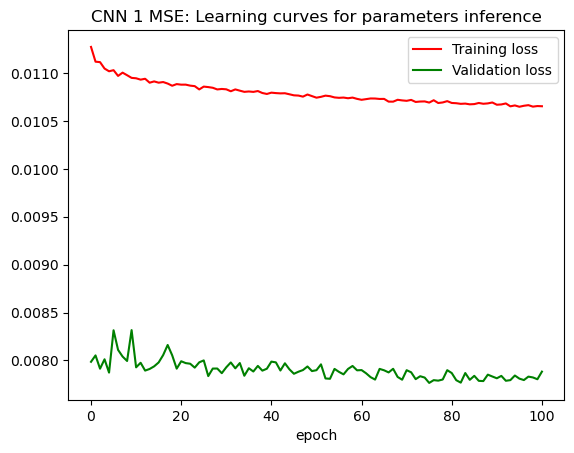

In [58]:
# Training
# CNN_1 = keras.models.load_model(path+"CNN_1")

start=time.time()

history_1 = training(CNN_1, batch_size=2048, patience=100, min_diff=0.001, loss=tf.keras.losses.MeanSquaredError(), optim=tf.keras.optimizers.Nadam(learning_rate=1e-4))
train_duration = time.time()-start 

print(f" Training with {train_size} training data took {train_duration/60} minutes")

# Results
plot_curves("CNN 1 MSE", history_1)

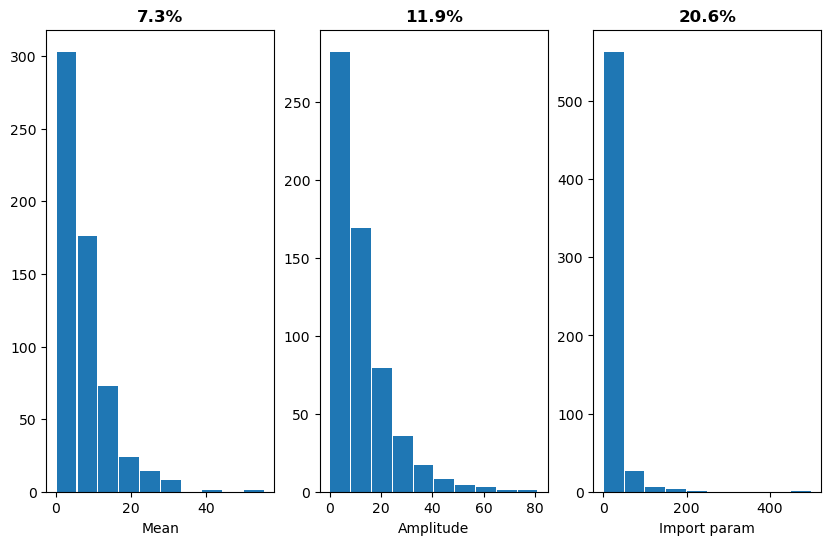

In [25]:
CNN_1 = keras.models.load_model(path+"CNN_1")
f=compute_error(CNN_1)
plt.show()

In [79]:
# Save if interesting
CNN_1.save(path+"CNN_1")

2023-01-13 11:01:09.171128: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: New Data/CNN_1/assets


Epoch 1/1000
243/243 [==============================] - 13s 48ms/step - loss: 0.0166 - val_loss: 0.0106
Epoch 2/1000
243/243 [==============================] - 11s 46ms/step - loss: 0.0162 - val_loss: 0.0103
Epoch 3/1000
243/243 [==============================] - 11s 46ms/step - loss: 0.0160 - val_loss: 0.0101
Epoch 4/1000
243/243 [==============================] - 11s 46ms/step - loss: 0.0160 - val_loss: 0.0105
Epoch 5/1000
243/243 [==============================] - 11s 47ms/step - loss: 0.0160 - val_loss: 0.0104
Epoch 6/1000
243/243 [==============================] - 11s 47ms/step - loss: 0.0160 - val_loss: 0.0103
Epoch 7/1000
243/243 [==============================] - 11s 47ms/step - loss: 0.0160 - val_loss: 0.0106
Epoch 8/1000
243/243 [==============================] - 11s 47ms/step - loss: 0.0159 - val_loss: 0.0103
Epoch 9/1000
243/243 [==============================] - 11s 47ms/step - loss: 0.0160 - val_loss: 0.0109
Epoch 10/1000
243/243 [==============================] - 12s 47m

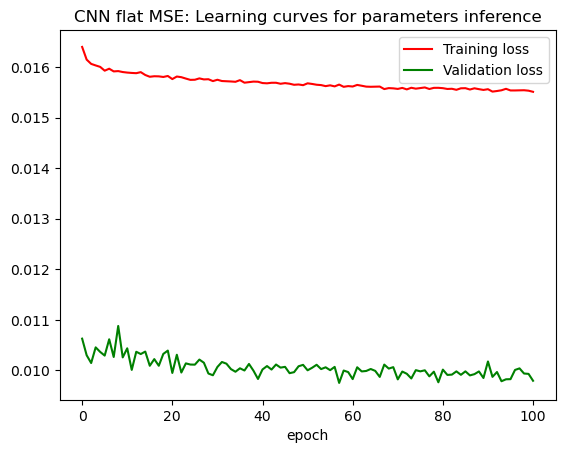

In [282]:
# Training
# CNN_flat = keras.models.load_model(path+"CNN_2")

start=time.time()

history_2 = training(CNN_flat, batch_size=2048, patience=100, min_diff=0.001, loss=tf.keras.losses.MeanSquaredError(), optim=tf.keras.optimizers.Nadam(learning_rate=1e-4))
train_duration = time.time()-start 

print(f" Training with {train_size} training data took {train_duration/60} minutes")

# Results
plot_curves("CNN flat MSE", history_2)

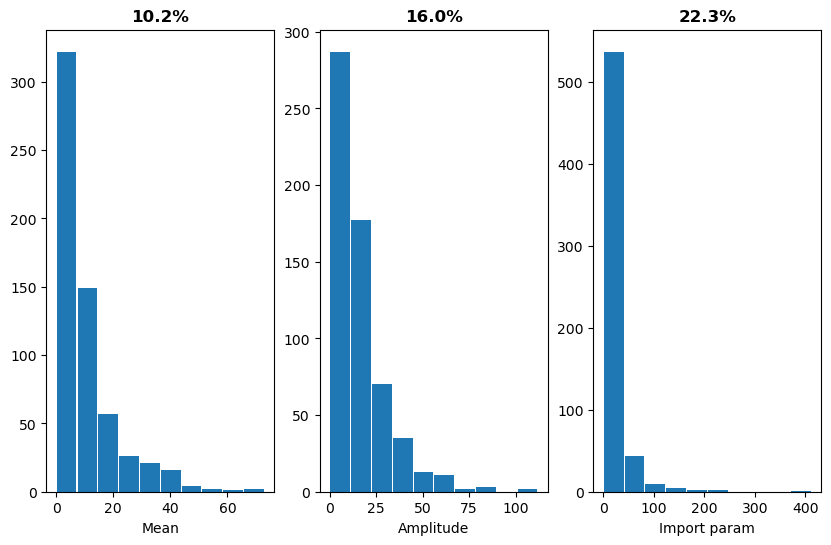

In [26]:
CNN_2 = keras.models.load_model(path+"CNN_2")
f=compute_error(CNN_2)
plt.show()

In [286]:
CNN_flat.save(path+"CNN_2")

INFO:tensorflow:Assets written to: New Data/CNN_2/assets


Epoch 1/1000
486/486 [==============================] - 32s 64ms/step - loss: 0.0166 - val_loss: 0.0176
Epoch 2/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0163 - val_loss: 0.0212
Epoch 3/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0162 - val_loss: 0.0189
Epoch 4/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0162 - val_loss: 0.0206
Epoch 5/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0161 - val_loss: 0.0203
Epoch 6/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 7/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0161 - val_loss: 0.0196
Epoch 8/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0161 - val_loss: 0.0183
Epoch 9/1000
486/486 [==============================] - 31s 64ms/step - loss: 0.0161 - val_loss: 0.0209
Epoch 10/1000
486/486 [==============================] - 31s 64m

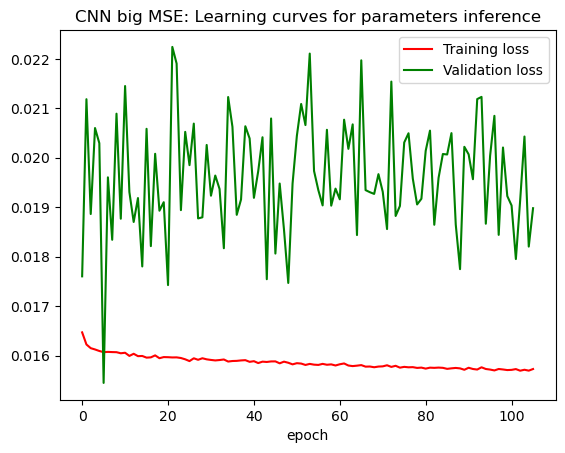

In [284]:
# Training
CNN_big = keras.models.load_model(path+"CNN_3")

start=time.time()

history_3 = training(CNN_big, batch_size=1024, patience=100, min_diff=0.001, loss=tf.keras.losses.MeanSquaredError(), optim=tf.keras.optimizers.Nadam(learning_rate=1e-4))
train_duration = time.time()-start 

print(f" Training with {train_size} training data took {train_duration/60} minutes")

# Results
plot_curves("CNN big MSE", history_3)

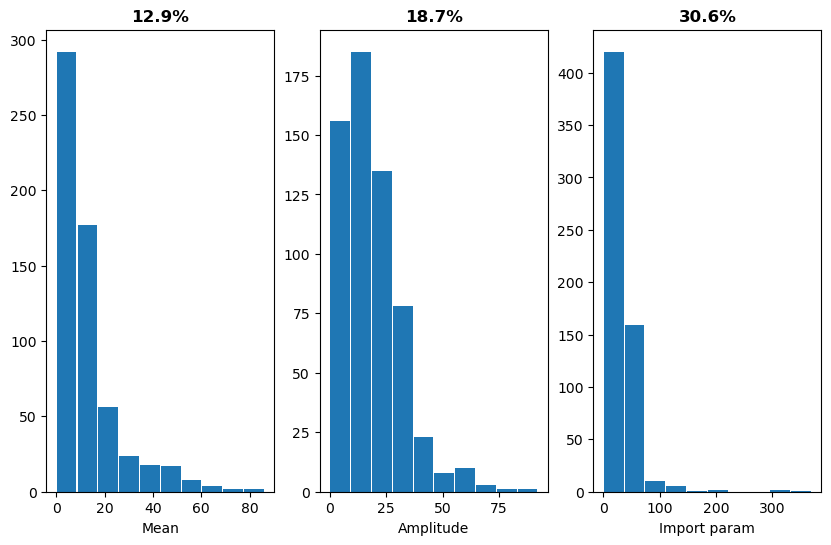

In [27]:
CNN_big= keras.models.load_model(path+"CNN_3")
compute_error(CNN_big)
plt.show()

In [49]:
CNN_big.save('New Data/CNN_3')

INFO:tensorflow:Assets written to: New Data/CNN_big/assets


# After training

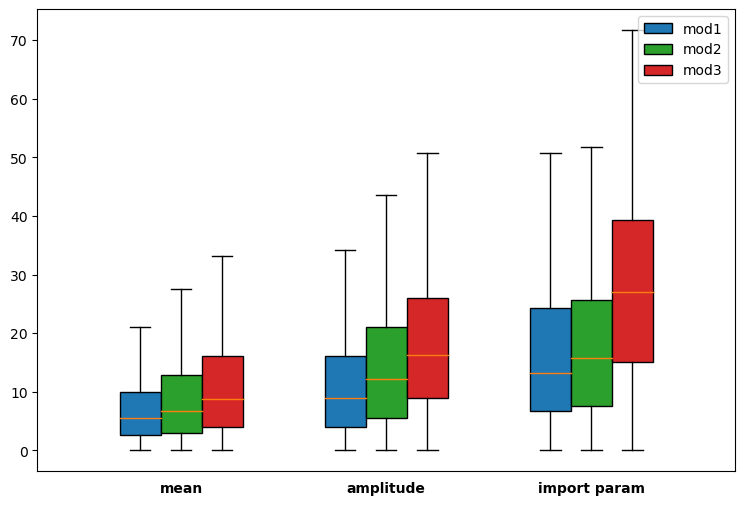

In [28]:
mod1 = keras.models.load_model(path+"CNN_1")
mod2 = keras.models.load_model(path+"CNN_2")
mod3 = keras.models.load_model(path+"CNN_3")

compare(mod1, mod2, mod3)

## *Relation between accuracy and tree size*

In the Voznica's article, they noticed that the accuracy of deep learning methods increaced with tree size. Let's see with our results ...

In [31]:
from sklearn.linear_model import LinearRegression

def relation_size_error(mod, param, inputs=inputs4[:600], labels=labels4[:600]):
    """
    Plot the errors of predictions according to tree size, for a given neural network
    And compute the linear regression between errors and tree size
    
    Parameters
    --------------------------
    param : int, indice of the corresponding parameter in column
    mod : class, trained neural network
    
    """
    
    RE,_ = compute_error(mod, inputs=inputs, labels=labels, plot=False)
    
    # Compute the tree size of each input vector, 
    # which is the number of positive coefficient in the leaf column
    X = []
    for vect in inputs:
        leaves = vect[:-1,0] 
        X.append(len(leaves[leaves !=0])) # num

    Regressor = LinearRegression()
    x = np.array([X]).T
    reg = Regressor.fit(x, RE[:, param])
    sc = reg.score(x, RE[:,param])
    print('The coefficient of determination of the prediction ', sc)
    coeff = reg.coef_
    b = reg.intercept_
    
    fig = plt.figure()
    plt.plot(X, RE[:,param], '.r', label='')
    plt.ylim([0,200])
    plt.plot(x, coeff*x+b, label=str(round(coeff[0],4))+'.x+'+str(round(b,2)))
    plt.xlabel('Tree size')
    plt.ylabel('Relative error')
    plt.legend()
    plt.title(params_to_infer[param], fontweight='bold')
    plt.text(100, 180, '$R²:$'+ str(round(sc,3)), fontweight='bold')

    plt.show()
    
    return fig

The coefficient of determination of the prediction  0.11101665691987073


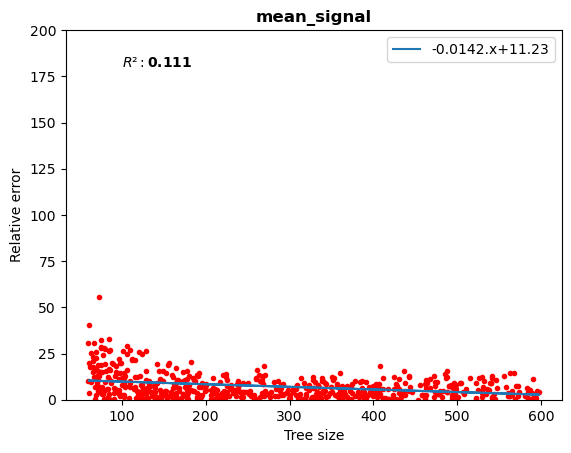

In [32]:
fig = relation_size_error(mod1, 0)

The coefficient of determination of the prediction  0.1650443693211895


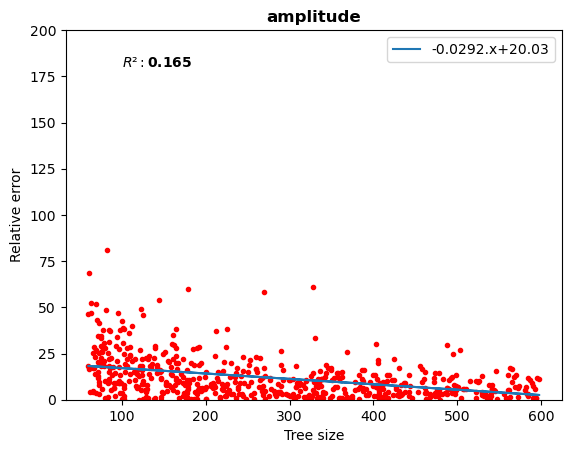

In [33]:
fig = relation_size_error(mod1, 1)

The coefficient of determination of the prediction  0.017682164268811307


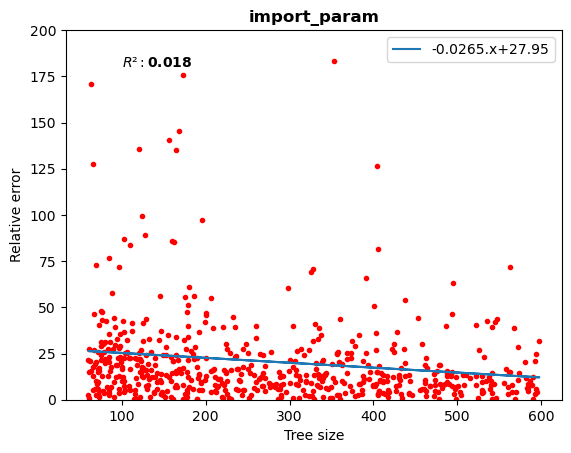

In [34]:
fig = relation_size_error(mod1, 2)

## *Comparision with null models*
To know how much and how fast neural networks learn
Null model 1 : a random predictor (https://www.tensorflow.org/tutorials/customization/custom_layers)

In [40]:
# Null model 
class RandomPredictor(tf.keras.layers.Layer):
    def __init__(self, num_samples):
        # do all input-independent initialization
        super(RandomPredictor, self).__init__()
        self.num_samples = num_samples
    
    # where you know the shapes of the input tensors and can do the rest of the initialization
    def build(self, input_shape):
        # parameter_subpace : array of shape (number of parameters, 2) containing min and max values for each parameters
        
        self.num_param = input_shape[0]

    # do the forward computation
    def call(self, parameter_subspace):
        # returns : predictions of shape (self.num_samples, self.um_param)
        
        random_target = []
        
        for i in range(self.num_param):
            # random_target.append(np.random.uniform(parameter_subspace[i, 0], parameter_subspace[i, 1]))
            random_target.append(np.random.uniform(parameter_subspace[i, 0], parameter_subspace[i, 1], self.num_samples))
            
             
        return tf.transpose(tf.convert_to_tensor(random_target))
    
# TEST 
layer = RandomPredictor(5)
params = np.array([[0,1],  [45,96], [45,85]])
print(params.shape)
layer(params)

(3, 2)


<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[2.43181710e-02, 8.62432612e+01, 6.64547007e+01],
       [7.28875683e-01, 6.47048507e+01, 6.58065587e+01],
       [6.54391613e-02, 4.61119866e+01, 7.88308244e+01],
       [2.80285238e-01, 8.42680401e+01, 4.91968618e+01],
       [6.47842101e-01, 9.57548480e+01, 8.14005893e+01]])>

In [36]:
factors4 = np.load(path+'4factors.npy')
factors4

array([10.79288382,  9.96701767, 13.62195035, ..., 12.169696  ,
       10.78128257, 12.86398795])

In [41]:
def error_random_predictor(batch_size, labels, factors):
    """
    Compute the error of random predictions
    
    Parameters
    -------------------------
    batch_size : int, number of predictions to make
    labels : tensor of shape (batch_size, 3), true values to compare with predictions
    factors : array of shape (batch_size, 1), rescale factor of each test data (mean_signal have to be rescale)
    
    Returns
    -------------------------
    RE : tensor of shape (batch_size, 3)
    MRE : tensor of shape (1, 3), mean absolute percentage error of each parameters
    
    """
    
    predictor = RandomPredictor(batch_size)
    
    param_subspace = np.array([[0.3, 0.7], [0.1, 1], [0, 15]])
    random_out = predictor(param_subspace)
    
    # In order to compare the error with the parameter B, we need to rescale random_out[:,0]
    c = random_out[:,0]*factors4[:600]
    random_out=tf.concat([c[:,None], random_out[:,1:]], 1)
    
    RE = tf.math.abs(labels - random_out)*100/labels
    MRE = tf.reduce_mean(RE, axis=0).numpy()
    
    return(RE, MRE)

In [42]:
R, M=error_random_predictor(600, labels4[:600], factors4[:600])
M

array([37.04741425, 91.40182043, 58.93603095])

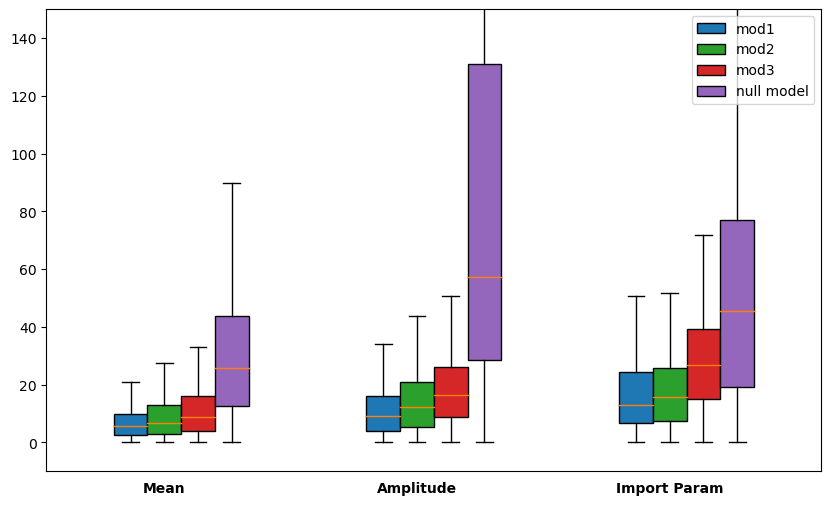

In [43]:
def compare_null(mod1, mod2, mod3):
    """
    Plot boxplot of absolute percentage errors for each parameters and each models
    """
    
    RE1, _ = compute_error(mod1, plot=False)
    RE2, _ = compute_error(mod2, plot=False)
    RE3, _ = compute_error(mod3, plot=False)
    RE_NULL, MRE_NULL = error_random_predictor(600, labels4[:600], factors4[:600])

    fig, ax = plt.subplots(1,1, figsize=(10, 6))

    t= np.array([1, 2.5, 4])
    bp1 = ax.boxplot(RE1.numpy(),positions=t, notch=False, widths=0.2, 
                     patch_artist=True, boxprops=dict(facecolor="C0"), showfliers=False)

    bp2 = ax.boxplot(RE2.numpy(), positions=t+0.2, notch=False, widths=0.2, 
                     patch_artist=True, boxprops=dict(facecolor="C2"), showfliers=False)

    bp3 = ax.boxplot(RE3.numpy(), positions=t+0.4, notch=False, widths=0.2, 
                     patch_artist=True, boxprops=dict(facecolor="C3"), showfliers=False)
                                
    bp4 = ax.boxplot(RE_NULL.numpy(), positions=t+0.6, notch=False, widths=0.2, 
                     patch_artist=True, boxprops=dict(facecolor="C4"), showfliers=False)
    
    ax.set_ylim([-10,150])


    ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]], ['mod1', 'mod2', 'mod3', 'null model'], loc='upper right')

    ax.set_xticklabels(['', '','', 'Mean', 'Amplitude', 'Import Param', '', '', '', '', '',''], fontweight='bold')

    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False)         # ticks along the top edge are off


    plt.show()
                                               
compare_null(mod1, mod2, mod3)

In [46]:
!zip -r model1.zip CNN_1

  adding: CNN_1/ (stored 0%)
  adding: CNN_1/assets/ (stored 0%)
  adding: CNN_1/saved_model.pb (deflated 90%)
  adding: CNN_1/variables/ (stored 0%)
  adding: CNN_1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: CNN_1/variables/variables.index (deflated 69%)


In [45]:
help(tar)

NameError: name 'tar' is not defined